In [ ]:
!pip install cupy-cuda100 -user
!pip install snakeviz
!pip install mpi4py


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 282 kB 15.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438438 sha256=eaf59c6d5a370f720131e3a744099870988c4f48d52fc9372afda3fd9f791c37
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9

In [ ]:
import cupy as cp
import cupyx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import cProfile

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20

In [ ]:
%load_ext snakeviz

## Task Saxpy

By using <u><i><strong>CuPy</strong></i></u>, implement SAXPY function. The function is described in the picture.

In [ ]:
saxpy_kernel = cp.ElementwiseKernel(
    'float32 x, float32 y, float32 alpha',
    'float32 z',
    'z = alpha * x + y',
    'saxpy_kernel')

saxpy_native_np = lambda x, y, alpha: x * alpha + y
saxpy_einsum_np = lambda x, y, alpha: np.einsum(',i', alpha, x) + y
saxpy_einsum_cp = lambda x, y, alpha: cp.einsum(',i', alpha, x) + y

In [ ]:
x = cp.random.rand(10000, dtype='float32')
y = cp.random.rand(10000, dtype='float32')
alpha = cp.random.rand(1, dtype='float32')[0]

print(f'Results with elementwise kernel and native mupy kernel are identical: \
{cp.allclose(saxpy_native_np(x, y, alpha), saxpy_kernel(x, y, alpha))}')

Results with elementwise kernel and native mupy kernel are identical: True


In [ ]:
%timeit saxpy_native_np(x, y, alpha)

42.4 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit saxpy_kernel(x, y, alpha)

10.6 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


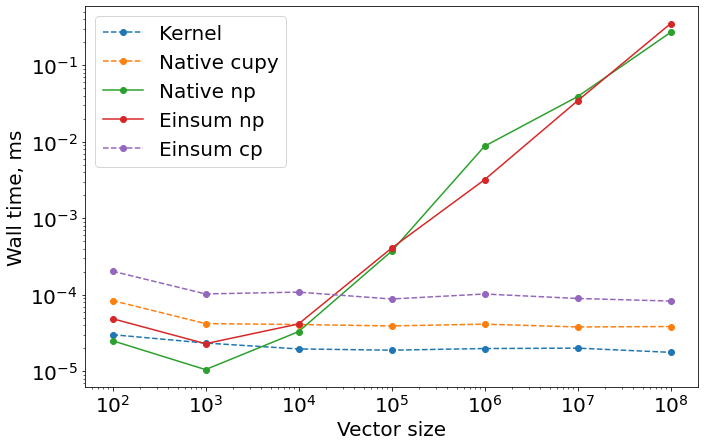

In [ ]:
array_sizes = 10 ** np.arange(2, 9, 1)

def wall_time_np(func, arr_size):
    x = np.random.rand(arr_size)
    y = np.random.rand(arr_size)
    alpha = np.random.rand(1)[0]

    t = time.time()
    _ = func(x, y, alpha)
    t = time.time() - t
    return t

def wall_time_cp(func, arr_size):
    x = cp.random.rand(arr_size, dtype='float32')
    y = cp.random.rand(arr_size, dtype='float32')
    alpha = cp.random.rand(1, dtype='float32')[0]

    t = time.time()
    _ = func(x, y, alpha)
    t = time.time() - t
    return t

time_kernel = [wall_time_cp(saxpy_kernel, arr_size) for arr_size in array_sizes]
time_native_cp = [wall_time_cp(saxpy_native_np, arr_size) for arr_size in array_sizes]
time_native_np = [wall_time_np(saxpy_native_np, arr_size) for arr_size in array_sizes]
time_einsum_np = [wall_time_np(saxpy_einsum_np, arr_size) for arr_size in array_sizes]
time_einsum_cp = [wall_time_cp(saxpy_einsum_cp, arr_size) for arr_size in array_sizes]


plt.plot(array_sizes, time_kernel, '--o', label='Kernel')
plt.plot(array_sizes, time_native_cp, '--o', label='Native cupy')
plt.plot(array_sizes, time_native_np, '-o', label='Native np')
plt.plot(array_sizes, time_einsum_np, '-o', label='Einsum np')
plt.plot(array_sizes, time_einsum_cp, '--o', label='Einsum cp')
plt.xlabel('Vector size')
plt.ylabel('Wall time, ms')
plt.legend()
plt.yscale('log');
plt.xscale('log');

## Task CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map (Task 1).

In [ ]:
def bifurcation_map_np(x0, r, n=200):
    x_arr = np.array([x0])
    for _ in np.arange(n-1):
        x_1 = r * x_arr[-1] * (1 - x_arr[-1])
        x_arr = np.append(x_arr, x_1)
    return x_arr

def bif_map_4_r_np(x0, r, k=0, n=200):
    assert isinstance(r, (np.ndarray))
    assert k <= n
    
    arr_xri = bifurcation_map_np(x0, r[0], n)[-int(k):]
    for r_i in r[1:]:
        x_ri = bifurcation_map_np(x0, r_i, n)
        arr_xri = np.vstack([arr_xri, x_ri[-int(k):]])

    arr_xri = np.append(r.reshape(-1, 1), arr_xri, axis=1)
    return arr_xri

def bifurcation_map(x0, r, n=200):
    x_arr = cp.array([x0])
    for _ in cp.arange(n-1):
        x_1 = r * x_arr[-1] * (1 - x_arr[-1])
        x_arr = cp.append(x_arr, x_1)
    return x_arr

def bif_map_4_r(x0, r, k=0, n=200):
    assert isinstance(r, (cp.ndarray))
    assert k <= n
    
    arr_xri = bifurcation_map(x0, r[0], n)[-int(k):]
    for r_i in r[1:]:
        x_ri = bifurcation_map(x0, r_i, n)
        arr_xri = cp.vstack([arr_xri, x_ri[-int(k):]])

    arr_xri = cp.append(r.reshape(-1, 1), arr_xri, axis=1)
    return arr_xri

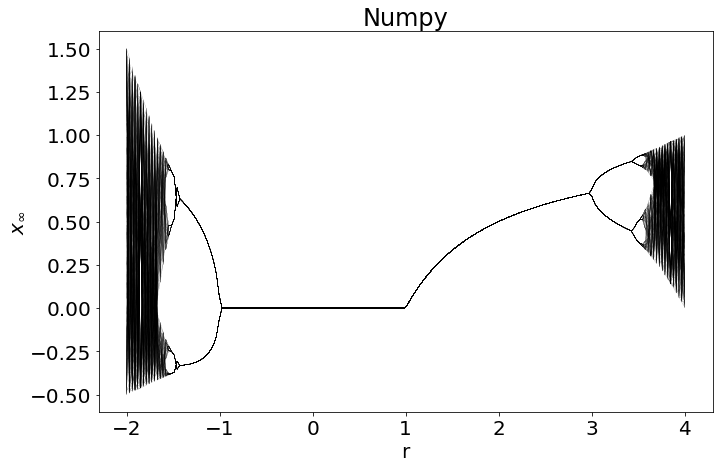

In [ ]:
n = 400
k = 200
arr_ = bif_map_4_r_np(np.random.uniform(0, 1), r=np.linspace(-2, 4, 200), k=k, n=n)

plt.plot([[r] * k for r in arr_[:, 0]], arr_[:, 1:], 'k', lw=.1)
plt.xlabel('r')
plt.ylabel('$x_{\infty}$')
plt.title('Numpy');

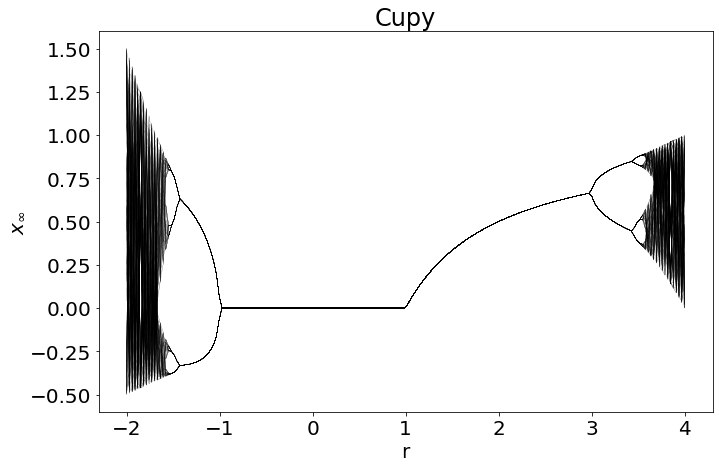

In [ ]:
n = 400
k = 200
arr_ = bif_map_4_r(cp.random.uniform(0, 1), r=cp.linspace(-2, 4, 200), k=k, n=n)
arr_ = cp.asnumpy(arr_)

plt.plot([[r] * k for r in arr_[:, 0]], arr_[:, 1:], 'k', lw=.1)
plt.xlabel('r')
plt.ylabel('$x_{\infty}$')
plt.title('Cupy');

In [ ]:
%timeit arr_ = bif_map_4_r_np(np.random.uniform(0, 1), r=np.linspace(-2, 4, 200), k=200, n=400)

439 ms ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit arr_ = bif_map_4_r(cp.random.uniform(0, 1), r=cp.linspace(-2, 4, 200), k=200, n=400)

9.18 s ± 845 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def main_bif_cupy():
    n = 1500
    k = 200
    arr_ = bif_map_4_r(cp.random.uniform(0, 1), r=cp.linspace(-2, 4, 840), k=k, n=n)

In [ ]:
cProfile.run('main_bif_cupy()')

         22700888 function calls (22700870 primitive calls) in 149.190 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       60    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
  1259160    0.932    0.000    3.771    0.000 <__array_function__ internals>:2(min_scalar_type)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
      840   74.939    0.089  146.525    0.174 <ipython-input-4-373c7a305afb>:21(bifurcation_map)
        1    0.017    0.017  146.938  146.938 <ipython-input-4-373c7a305afb>:28(bif_map_4_r)
        1    0.000    0.000  149.190  149.190 <ipython-input-5-812dd80f1c68>:1(main_bif_cupy)
        1    0.000    0.000  149.190  149.190 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:354(result_type)
        1    0.000    0.000    0.000    0.000 __init__.py:360(<listcomp>)
        2    0.000    0.000    0.000    0

In [ ]:
%%writefile bif_mpi_1500.py
from mpi4py import MPI
import numpy as np
import time

def bifurcation_map(x0, r, n=200):
    x_arr = np.array([x0])
    for _ in np.arange(n-1):
        x_1 = r * x_arr[-1] * (1 - x_arr[-1])
        x_arr = np.append(x_arr, x_1)
    return x_arr

def bif_map_4_r(x0, r, k=0, n=200):
    assert isinstance(r, (list, tuple, set, np.ndarray))
    assert k <= n
    
    arr_xri = bifurcation_map(x0, r[0], n)[-int(k):]
    for r_i in r[1:]:
        x_ri = bifurcation_map(x0, r_i, n)
        arr_xri = np.vstack([arr_xri, x_ri[-int(k):]])

    arr_xri = np.insert(arr_xri, 0,  r, 1)
    return arr_xri

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

mpi_wall_t = MPI.Wtime()
calc_t = time.time()

n = 1500    # Total number of iterations
k = 200     # Number of last iterations to use
x0 = np.random.uniform(0, 1)

r_space = np.linspace(-2, 4, 840)
r_per_rank = np.split(r_space, size)
r_subspace = r_per_rank[rank]

arr_rank = bif_map_4_r(x0, r_subspace, k, n)
calc_t = time.time() - calc_t

gather_t = time.time()
result_arr = comm.gather(arr_rank, root=0)
gather_t = time.time() - gather_t

mpi_wall_t = MPI.Wtime() - mpi_wall_t

if rank == 0:
    result_arr = np.concatenate(result_arr, 0)
    np.savez('bif_mpi' + str(n) + '.npz', mpi_wall_t=mpi_wall_t)

Overwriting bif_mpi_1500.py


In [ ]:
!mpirun --allow-run-as-root -n 3 python bif_mpi_1500.py

In [ ]:
n_arr = [100, 500, 800, 1000, 1200, 1500]

def main_bif_all(n_arr):
    cp_bif_t = []
    np_bif_t = []
    for n in n_arr:
        print(n)
        k = 100 if n == 100 else 200

        t_ = time.time()
        _ = bif_map_4_r_np(np.random.uniform(0, 1), r=np.linspace(-2, 4, 840), k=k, n=n)
        t_ = time.time() - t_
        np_bif_t.append(t_)

        t_ = time.time()
        _ = bif_map_4_r(cp.random.uniform(0, 1), r=cp.linspace(-2, 4, 840), k=k, n=n)
        t_ = time.time() - t_
        cp_bif_t.append(t_)
    return np_bif_t, cp_bif_t

np_bif_t, cp_bif_t = main_bif_all(n_arr)

100
500
800
1000
1200
1500


In [ ]:
mpi_bif_t = []
for n in n_arr:
    t_ = np.load('bif_mpi' + str(n) + '.npz')['mpi_wall_t']
    mpi_bif_t.append(t_)

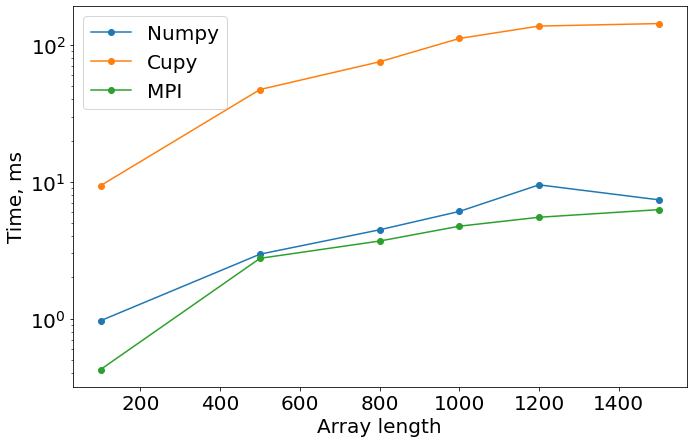

In [ ]:
plt.plot(n_arr, np_bif_t, '-o', label='Numpy')
plt.plot(n_arr, cp_bif_t, '-o', label='Cupy')
plt.plot(n_arr, mpi_bif_t, '-o', label='MPI')

plt.yscale('log')
plt.legend()
plt.xlabel('Array length')
plt.ylabel('Time, ms');

## Task Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

<strong >Hint about function $f(x)$ appearance:</strong>
    ![Hint](Hint.png)

In [ ]:
# Implement function
def func_task12(x):
    assert isinstance(x, cp.ndarray)
    z = cp.sin(3 * x) - .5
    y = (z * z + z * z * z - 200 * z ** 4) * cp.sin(1e5 * (x + .5))
    return y

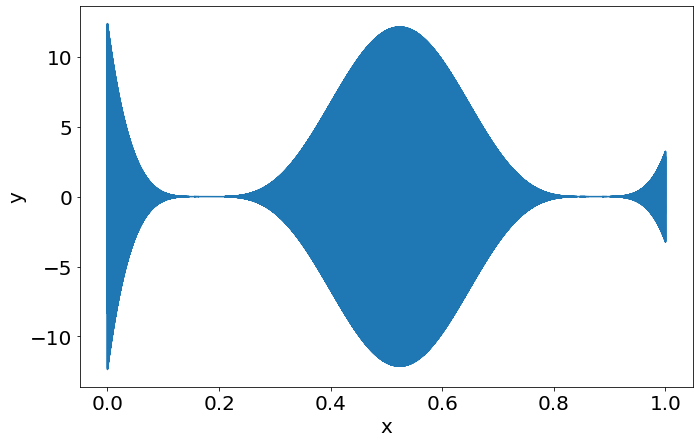

In [ ]:
# Plot function on specified interval
x_space = cp.linspace(0, 1, int(1e7))
np_x_space = cp.asnumpy(x_space)

cp_res = func_task12(x_space)
np_res = cp.asnumpy(cp_res)

plt.plot(np_x_space, np_res)
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
# Min and max values
y_min = cp.min(cp_res)
y_max = cp.max(cp_res)
print(f'f_min(x) = {y_min:.3f}\nf_max(x) = {y_max:.3f}')

f_min(x) = -12.366
f_max(x) = 12.375


In [ ]:
# Divide to subintervals
def divide_res(arr, folds=10):
    assert isinstance(arr, cp.ndarray)

    y_max = cp.max(arr)
    y_min = cp.min(arr)
    d = folds / 100 * (y_max - y_min)

    min_max_interval = bound_array(arr, y_min, y_max)
    
    interval_bounds = cp.vstack([[y_min, y_min] for _ in range(10)])
    deltas = cp.vstack([[d * i, d* (i+1)] for i in range(10)])
    interval_bounds = interval_bounds + deltas

    #print(interval_bounds)
    
    subintervals = []
    for bot, ceil in interval_bounds:
        step_arr = bound_array(min_max_interval, bot, ceil)
        subintervals.append(step_arr)

    return subintervals, interval_bounds

def bound_array(arr, bot, ceil):
    out = arr[cp.where(arr <= ceil)[0]]
    out = out[cp.where(out >= bot)[0]]
    return out

subintervals, interval_bounds = divide_res(cp_res)

In [ ]:
interval_bounds[:, 0]

array([-1.23655447e+01, -9.89149897e+00, -7.41745327e+00, -4.94340758e+00,
       -2.46936188e+00,  4.68381395e-03,  2.47872951e+00,  4.95277521e+00,
        7.42682090e+00,  9.90086660e+00])

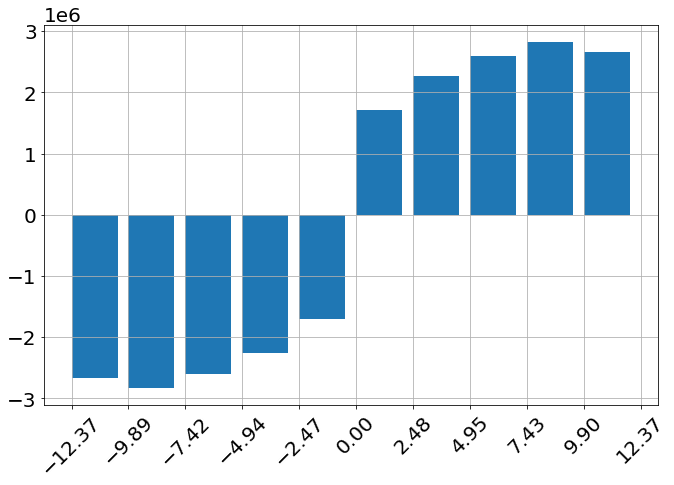

In [ ]:
# Histogram
hist_y = [cp.sum(entry).get() for entry in subintervals]
# hist_x = cp.append(interval_bounds[:, 0], interval_bounds[-1, 1])
hist_x = interval_bounds[:, 0]
hist_x = cp.asnumpy(hist_x)

plt.bar(hist_x, hist_y, align='edge', width=2)
plt.grid()
plt.xticks(np.append(hist_x, cp.asnumpy(interval_bounds[-1, 1])), rotation=45);

In [ ]:
%timeit [cp.sum(entry).get() for entry in subintervals]

751 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
subintervals_np = [cp.asnumpy(subint) for subint in subintervals]

In [ ]:
%timeit [np.sum(entry) for entry in subintervals_np]

6.43 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Task Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image and 

<strong >Example of a blurred image:</strong>
    ![Blur](blur.jpg)

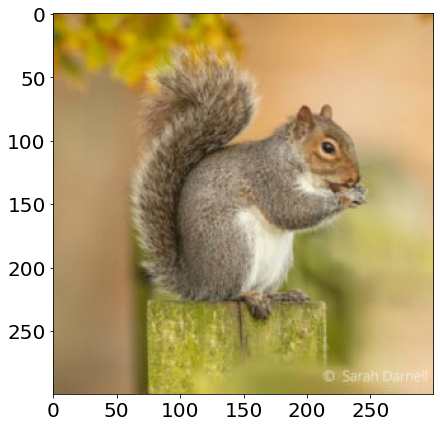

In [ ]:
from scipy.signal import convolve2d as convolve2d_cpu
from cupyx.scipy.signal import convolve2d as convolve2d_gpu
from skimage.util import img_as_float

from PIL import Image
import requests
from io import BytesIO

# 1,482 x 1,482
# response = requests.get('https://upload.wikimedia.org/wikipedia/commons/1/15/EasternGraySquirrel_GAm.jpg)

# 1,100 x 824
# response = requests.get('https://media.npr.org/assets/img/2017/04/25/istock-115796521-fcf434f36d3d0865301cdcb9c996cfd80578ca99-s1100-c50.jpg')

# 300 x 300
response = requests.get('https://www.mammal.org.uk/wp-content/uploads/2021/09/gsq-300x300.jpg')

# 100 x 100
# response = requests.get('https://www.baronfineart.co.uk/wp-content/uploads/2022/02/Carl-Whitfield-Squirrel-100x100.jpg')


img = Image.open(BytesIO(response.content))
img = np.asarray(img, dtype=np.uint8)
img = img_as_float(img)
plt.imshow(img);

In [ ]:
from scipy.linalg import pascal
from scipy.special import binom

def gauss_approx(size):
    '''Based on Pascal traiangle'''
    return [binom(size-1, i) for i in range(size)]

def gauss_blur_kernel_np(size):
    vec = gauss_approx(size)
    coeff = np.sum(vec) ** 2
    return np.einsum('i,j->ij', vec, vec) / coeff

def gauss_blur_kernel_cp(size):
    vec = gauss_approx(size)
    vec = cp.asarray(vec)
    coeff = cp.sum(vec) ** 2
    return cp.einsum('i,j->ij', vec, vec) / coeff

In [ ]:
def scipy_conv(img, kernel_size):
    kernel = gauss_blur_kernel_np(kernel_size)
    channel_1 = convolve2d_cpu(img[:, :, 0], kernel, boundary='symm', mode='same')
    channel_2 = convolve2d_cpu(img[:, :, 1], kernel, boundary='symm', mode='same')
    channel_3 = convolve2d_cpu(img[:, :, 2], kernel, boundary='symm', mode='same')
    return np.dstack([channel_1, channel_2, channel_3])

def cupy_conv(img, kernel_size):
    kernel = gauss_blur_kernel_cp(kernel_size)
    channel_1 = convolve2d_gpu(img[:, :, 0], kernel, boundary='symm', mode='same')
    channel_2 = convolve2d_gpu(img[:, :, 1], kernel, boundary='symm', mode='same')
    channel_3 = convolve2d_gpu(img[:, :, 2], kernel, boundary='symm', mode='same')
    return cp.dstack([channel_1, channel_2, channel_3])

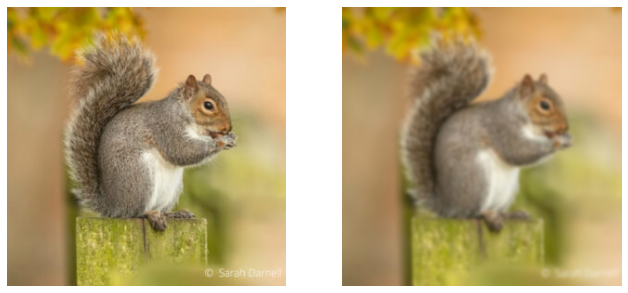

In [ ]:
kernel = gauss_blur_kernel_np(10)
channel_1 = convolve2d_cpu(img[:, :, 0], kernel, boundary='symm', mode='same')
channel_2 = convolve2d_cpu(img[:, :, 1], kernel, boundary='symm', mode='same')
channel_3 = convolve2d_cpu(img[:, :, 2], kernel, boundary='symm', mode='same')

_, axes = plt.subplots(1, 2)
axes[0].imshow(img);
axes[1].imshow(np.dstack([channel_1, channel_2, channel_3]))

axes[0].axis('off')
axes[1].axis('off');

In [ ]:
def my_conv_loop_np(pic, kernel_size):
    pad_size = kernel_size // 2
    kernel = gauss_blur_kernel_np(kernel_size)

    local_pic = pad_zeros_np(pic, pad_size)
    w, h, c = local_pic.shape

    # print(pic.shape, local_pic.shape)
    convolved_pic = np.empty_like(local_pic)
    for k in range(c):
        for i in range(w-pad_size):
            i_loc = i + pad_size
            for j in range(h-pad_size):
                j_loc = j + pad_size
                pic_part = local_pic[
                                   i_loc-pad_size:i_loc+pad_size+1,
                                   j_loc-pad_size:j_loc+pad_size+1,
                                   k
                                   ]

                if pic_part.shape != (kernel_size, kernel_size):
                    pic_part = assert_padding_np(pic_part, [kernel_size, kernel_size])
                convolved_pic[i_loc, j_loc, k] = np.sum(pic_part * kernel)
                
    return convolved_pic[pad_size:-pad_size, pad_size:-pad_size]

def my_conv_loop_cp(pic, kernel_size):
    pad_size = kernel_size // 2
    kernel = gauss_blur_kernel_cp(kernel_size)

    local_pic = pad_zeros_cp(pic, pad_size)
    w, h, c = local_pic.shape

    convolved_pic = cp.empty_like(local_pic)
    for k in range(c):
        for i in range(w-pad_size):
            i_loc = i + pad_size
            for j in range(h-pad_size):
                j_loc = j + pad_size
                pic_part = local_pic[
                                   i_loc-pad_size:i_loc+pad_size+1,
                                   j_loc-pad_size:j_loc+pad_size+1,
                                   k
                                   ]

                if pic_part.shape != (kernel_size, kernel_size):
                    pic_part = assert_padding_cp(pic_part, [kernel_size, kernel_size])
                convolved_pic[i_loc, j_loc, k] = cp.sum(pic_part * kernel)
                
    return convolved_pic[pad_size:-pad_size, pad_size:-pad_size]

#-----
def assert_padding_np(pic, kernel_size):
    padded_again = np.zeros(kernel_size)
    padded_again[0:pic.shape[0], 0:pic.shape[1]] = pic
    return padded_again

def assert_padding_cp(pic, kernel_size):
    padded_again = cp.zeros(kernel_size)
    padded_again[0:pic.shape[0], 0:pic.shape[1]] = pic
    return padded_again

def pad_zeros_np(pic, pad_sizes):
    padded_pic = np.zeros([pic.shape[0]+2*pad_sizes, pic.shape[1]+2*pad_sizes, pic.shape[2]])
    padded_pic[pad_sizes:-pad_sizes, pad_sizes:-pad_sizes] = pic
    return padded_pic

def pad_zeros_cp(pic, pad_sizes):
    padded_pic = cp.zeros([pic.shape[0]+2*pad_sizes, pic.shape[1]+2*pad_sizes, pic.shape[2]])
    padded_pic[pad_sizes:-pad_sizes, pad_sizes:-pad_sizes] = pic
    return padded_pic

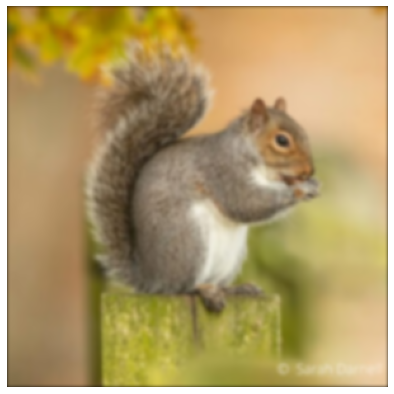

In [ ]:
check = my_conv_loop_np(img, 7)
plt.imshow(check)
plt.axis('off');

In [ ]:
from functools import partial 
from tqdm.notebook import tqdm

In [ ]:
my_conv_loop_np_7 = partial(my_conv_loop_np, kernel_size=7)
my_conv_loop_cp_7 = partial(my_conv_loop_cp, kernel_size=7)
scipy_conv_7 = partial(scipy_conv, kernel_size=7)
cupy_conv_7 = partial(cupy_conv, kernel_size=7)

funcs = [my_conv_loop_np_7, my_conv_loop_cp_7, scipy_conv_7, cupy_conv_7]
mode = ['np', 'cp', 'np', 'cp']

# 1,482 x 1,482
response4 = requests.get('https://upload.wikimedia.org/wikipedia/commons/1/15/EasternGraySquirrel_GAm.jpg')

# 1,100 x 824
response3 = requests.get('https://media.npr.org/assets/img/2017/04/25/istock-115796521-fcf434f36d3d0865301cdcb9c996cfd80578ca99-s1100-c50.jpg')

# 300 x 300
response2 = requests.get('https://www.mammal.org.uk/wp-content/uploads/2021/09/gsq-300x300.jpg')

# 100 x 100
response1 = requests.get('https://www.baronfineart.co.uk/wp-content/uploads/2022/02/Carl-Whitfield-Squirrel-100x100.jpg')

images = []

img1 = Image.open(BytesIO(response1.content))
img1 = np.asarray(img1, dtype=np.uint8)
img1 = img_as_float(img1)

img2 = Image.open(BytesIO(response2.content))
img2 = np.asarray(img2, dtype=np.uint8)
img2 = img_as_float(img2)

img3 = Image.open(BytesIO(response3.content))
img3 = np.asarray(img3, dtype=np.uint8)
img3 = img_as_float(img3)

img4 = Image.open(BytesIO(response4.content))
img4 = np.asarray(img4, dtype=np.uint8)
img4 = img_as_float(img4)

images = [img1, img2, img3, img4]

In [ ]:
def wall_t_conv(func, img):
    t_ = time.time()
    _ = func(img)
    t_ = time.time() - t_
    return t_

time_loop_np, time_loop_cp, time_scipy_conv, time_cupy_conv = [], [], [], []
time_ls = [time_loop_np, time_loop_cp, time_scipy_conv, time_cupy_conv]

for f, ls, m in tqdm(zip(funcs, time_ls, mode), total=len(funcs)):
    for im in tqdm(images):
        if m == 'cp':
            im = cp.asarray(im)
        w_t = wall_t_conv(f, im)
        ls.append(w_t)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

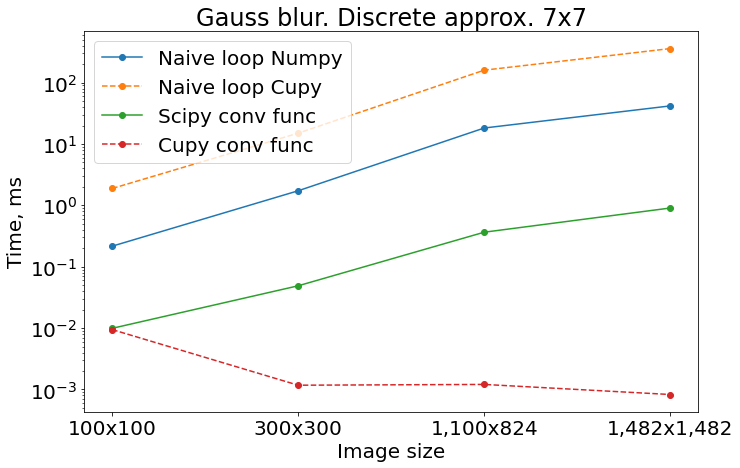

In [ ]:
plt.plot(range(4), time_loop_np, '-o', label='Naive loop Numpy')
plt.plot(range(4), time_loop_cp, '--o', label='Naive loop Cupy')
plt.plot(range(4), time_scipy_conv, '-o', label='Scipy conv func')
plt.plot(range(4), time_cupy_conv, '--o', label='Cupy conv func')

plt.xticks(range(4), ['100x100', '300x300', '1,100x824', '1,482x1,482'])

plt.yscale('log')
plt.legend()
plt.title('Gauss blur. Discrete approx. 7x7')
plt.xlabel('Image size')
plt.ylabel('Time, ms');